In [1]:
import pandas as pd
df = pd.read_csv(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\Actual_Training_Data_Final.csv")
dataset = df.drop('Unnamed: 0', axis=1)
dataset.head()

,B2,B3,B4,B8,Class
0,1294,1173,947,2278,0
1,1290,1171,965,2237,0
2,1287,1181,965,2265,0
3,1295,1184,983,2407,0
4,1314,1187,939,2765,0


In [2]:
# The dataset has two classes viz., 0 (Non-BuiltUp) and 255 (BuiltUp)
# Count of each class in the dataset
dataset['Class'].value_counts()

0      1551640
255     343760
Name: Class, dtype: int64

In [3]:
# Visualizing the count of each class using Bar graph
# Count of each class
ax = dataset['Class'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_xlabel('Class')
ax.set_ylabel('Count in percentage (%)')
ax.set_xticklabels(['Non-Built-up', 'Built-up'])

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+'%', xy = (p.get_x(), p.get_height()*1.005))

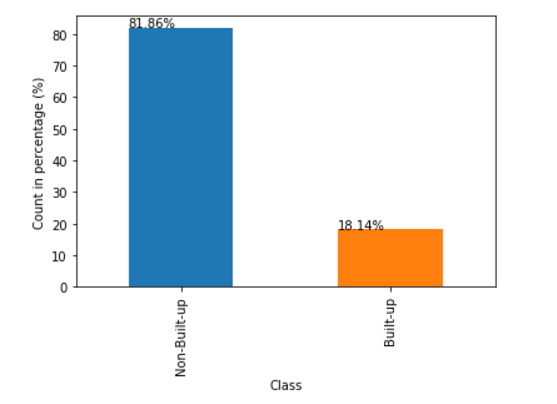

As you can see above, the dataset is highly imbalanced with 81.86% Non-BuiltUp and only 18.14% BuiltUp.

In [4]:
import numpy as np
# Spliting the dataset into independent and dependent variables
X = dataset.drop('Class', axis=1)
y = dataset['Class']
# Changing the value 255 to 1 in order to prevent error while computing different evaluation metrics
y_binary = y.values
y_binary[np.where(y_binary == 255)] = 1

In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size = 0.2, random_state = 42)

In [6]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # fitting the standard scaler with mean and standard deviation of the training dataset as well as transforming the training dataset
X_test = sc.transform(X_test)      #  transforming the testing dataset using the scaler that was fitted on the training datset

In [7]:
# Fitting the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

# Fit the model to training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [8]:
# How many nodes and how much maximum depth does the forest has on an average?

tree_nodes = []
max_depths = []

for decision_tree in rf.estimators_:
    tree_nodes.append(decision_tree.tree_.node_count)
    max_depths.append(decision_tree.tree_.max_depth)
    
print('On an average, the forest has {} nodes'.format(int(np.mean(tree_nodes))))
print('On an average, the forest has {} as the maximum depth'.format(int(np.mean(max_depths))))

On an average, the forest has 203649 nodes
On an average, the forest has 43 as the maximum depth


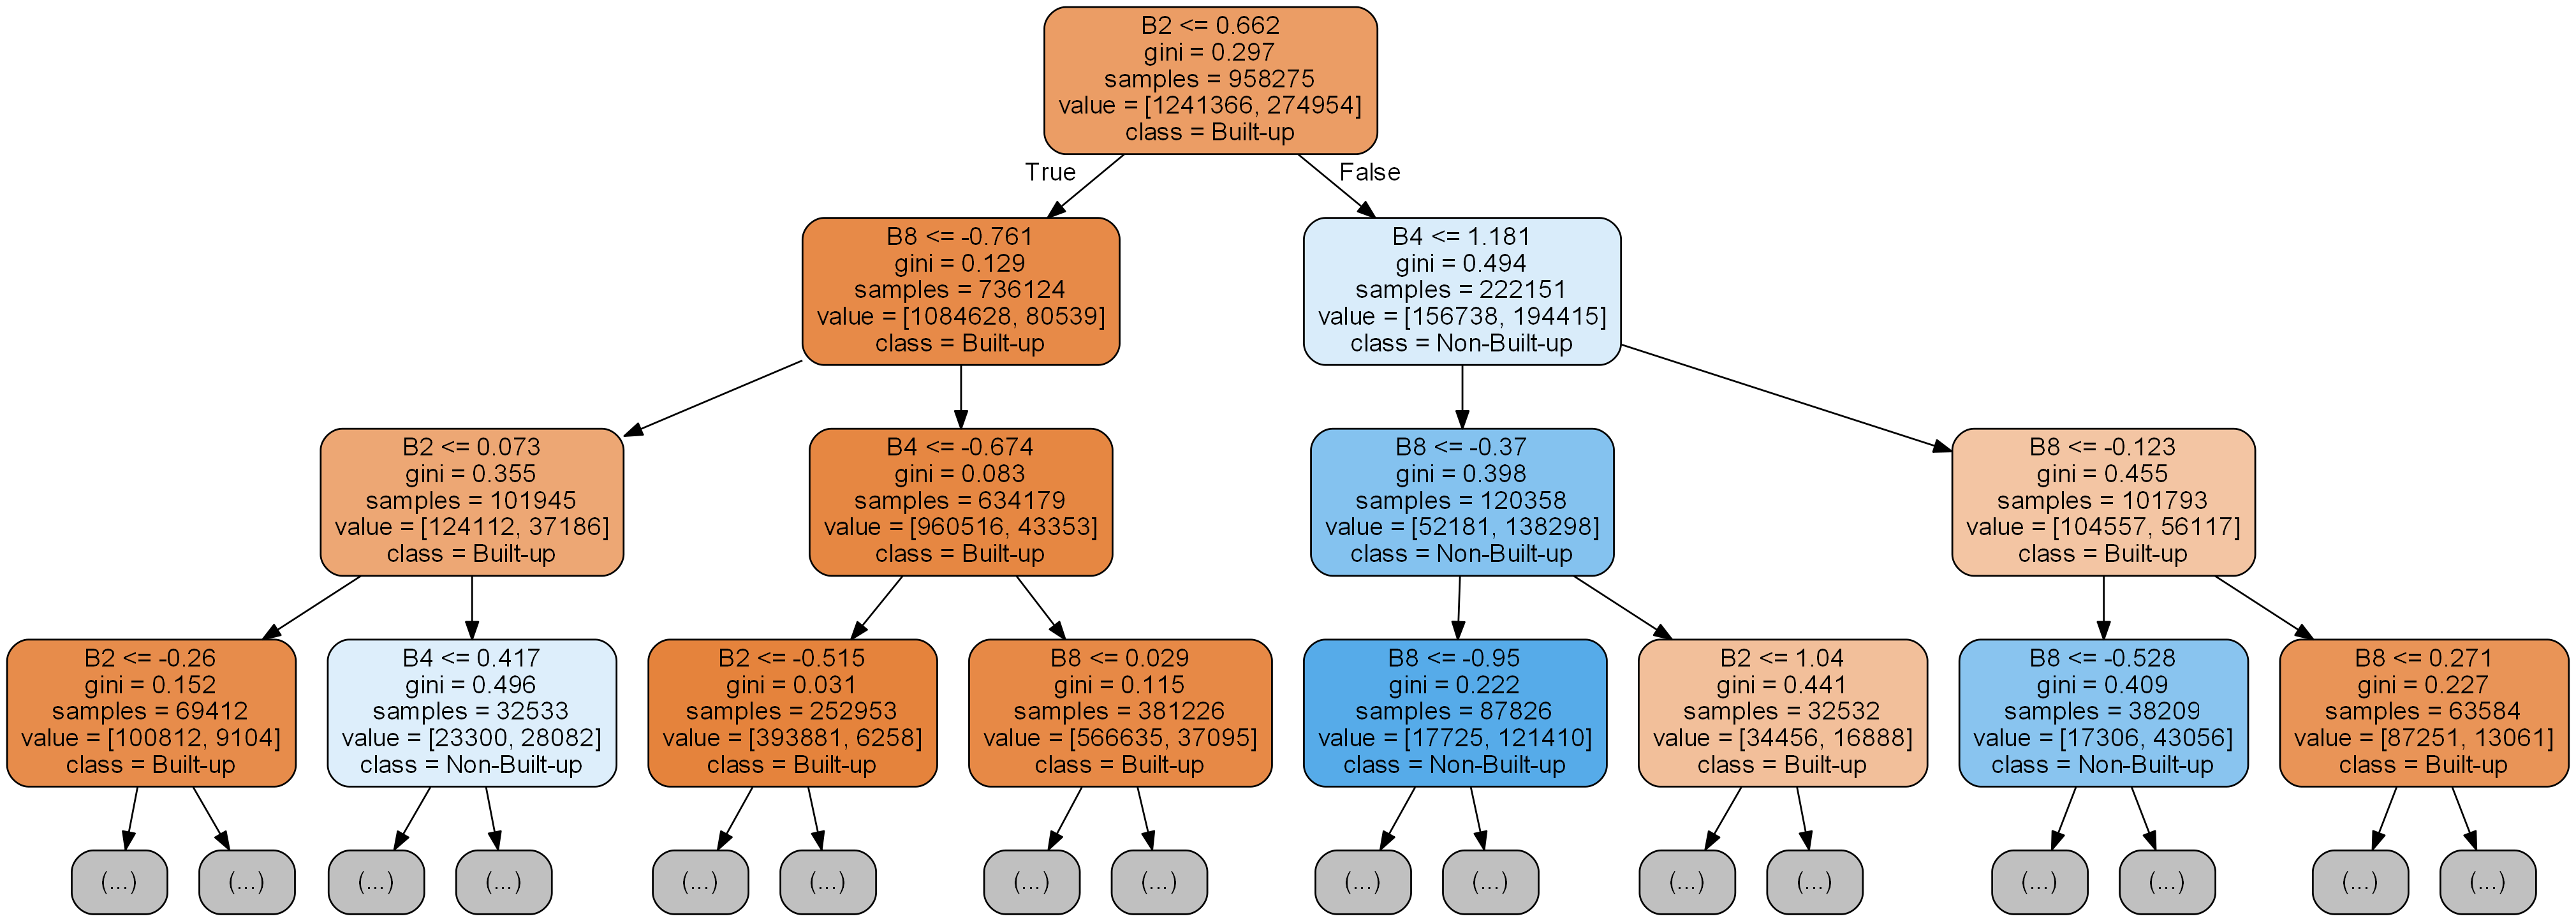

In [9]:
# How does a particular decision tree from the forest look?
estimator = rf.estimators_[3]

# Export a tree from the forest
from sklearn.tree import export_graphviz
export_graphviz(estimator, 'decision_tree.dot', rounded=True, max_depth=3,
                feature_names=['B2', 'B3', 'B4', 'B8'], class_names=['Built-up', 'Non-Built-up'], filled=True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'decision_tree.dot', '-o', 'decision_tree.png', '-Gdpi=200'], shell=True)


from IPython.display import Image
Image(filename=r'decision_tree.png')

In [10]:
# Predicting the Test set results
y_pred = rf.predict(X_test)

In [11]:
# How much importance is given to each feature by our model?
importance = pd.DataFrame({'Feature': ['B2', 'B3', 'B4', 'B8'],
                   'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)
importance

,Feature,Importance
0,B2,0.376754
3,B8,0.319916
2,B4,0.162282
1,B3,0.141048


In [12]:
# Predicting class probabilities
print("Negative Class: ", rf.classes_[0])
print("Positive Class: ", rf.classes_[1])
probs = rf.predict_proba(X_test)
probs

Negative Class:  0
Positive Class:  1


array([[1.  , 0.  ],
       [0.91, 0.09],
       [0.98, 0.02],
       ...,
       [0.81, 0.19],
       [0.98, 0.02],
       [0.87, 0.13]])

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[300368,  10339],
       [ 17077,  51296]], dtype=int64)

In [14]:
# The True Negatives, False Positives, False Negatives, True Positives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(300368, 10339, 17077, 51296)

In [15]:
# OOB Score
print('OOB Score: {oob}%'.format(oob=rf.oob_score_ * 100))

OOB Score: 92.69520945446872%


In [16]:
# Accuracy Score
from sklearn.metrics import accuracy_score
print( accuracy_score(y_test, y_pred) )

0.9276775350849424


In [17]:
# Classificaton Report 
import numpy as np
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9462    0.9667    0.9564    310707
           1     0.8323    0.7502    0.7891     68373

    accuracy                         0.9277    379080
   macro avg     0.8892    0.8585    0.8727    379080
weighted avg     0.9257    0.9277    0.9262    379080



In [18]:
# Kappa Statistic
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.7456166040839305


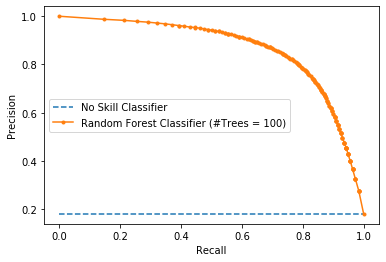

AUC: 0.865


In [19]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, probs[ : , 1])
auc_score = auc(recall, precision)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill Classifier')
plt.plot(recall, precision, marker='.', label='Random Forest Classifier (#Trees = 100)')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()
print('AUC: %.3f' % auc_score)

In [20]:
# Classifying whole image
X_all = sc.transform(X)

In [21]:
y_pred_all = rf.predict(X_all)

In [22]:
from osgeo import gdal, osr
ds2 = gdal.Open(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\built_up_mask.tif")
rf_img = y_pred_all.reshape(ds2.GetRasterBand(1).ReadAsArray().shape)

In [23]:
ds = gdal.Open(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\mora_clipped.tif")
def array2raster(newRasterfn, dataset, array, dtype):

    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]
    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])
    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    
array2raster(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\mora_imbalance_basic_final.tif", ds, rf_img, r"Byte")

Text(0.5, 0, 'Predicted Image')

<Figure size 432x288 with 0 Axes>

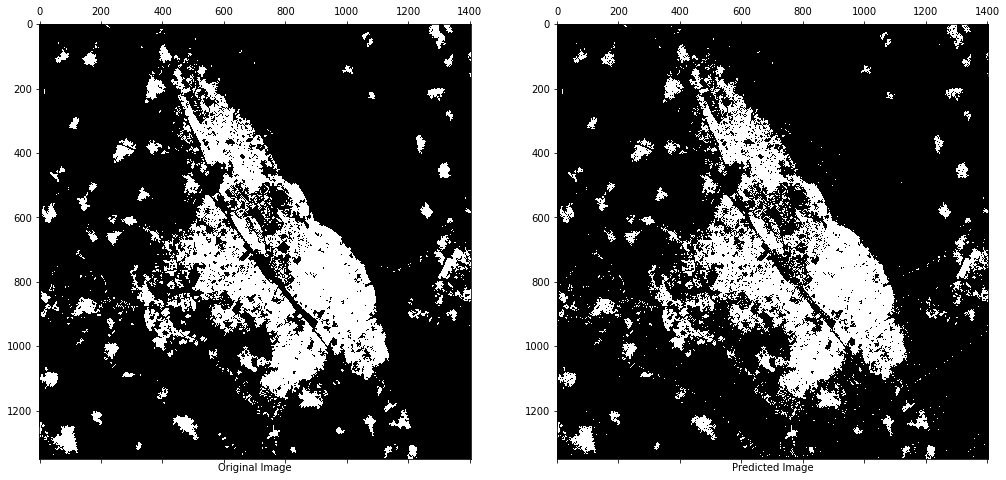

In [24]:
predicted = gdal.Open(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\mora_imbalance_basic_final.tif", gdal.GA_ReadOnly)
original = gdal.Open(r"D:\Sentinel-2A-2018\Moradabad\B(2)_G(3)_R(4)_Nir(8)_stacked_10m\built_up_mask.tif", gdal.GA_ReadOnly)

band_pred = predicted.GetRasterBand(1).ReadAsArray()
band_original = original.GetRasterBand(1).ReadAsArray()

fig = plt.figure()
fig, ax = plt.subplots(1,2,figsize=(17, 8))
ax[0].matshow(band_original, aspect="auto", cmap="Greys_r")
ax[0].set_xlabel('Original Image')
ax[1].matshow(band_pred, aspect="auto", cmap="Greys_r")
ax[1].set_xlabel('Predicted Image')

# Cross Validation

In [25]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=100)) 
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(clf, X, y_binary, cv = cv)
scores

array([0.92767754, 0.92789649, 0.92758257, 0.92766435, 0.92741374])

In [26]:
print('Accuracy: ',scores.mean())

Accuracy:  0.9276469346839716


In [27]:
print('Standard Deviation: ', scores.std())

Standard Deviation:  0.000156229935441238


In [28]:
precision_scores = cross_val_score(clf, X, y_binary, scoring = 'precision',cv = cv)
precision_scores

array([0.83641032, 0.83656537, 0.83523291, 0.83648279, 0.83391665])

In [29]:
print('Precision: ', precision_scores.mean())

Precision:  0.835721608659294


In [30]:
print('Standard Deviation: ', precision_scores.std())

Standard Deviation:  0.001025900843719749


In [31]:
recall_scores = cross_val_score(clf, X, y_binary, scoring = 'recall',cv = cv)
recall_scores

array([0.74908366, 0.74812369, 0.7475128 , 0.74982546, 0.74828369])

In [32]:
print('Recall: ', recall_scores.mean())

Recall:  0.7485658599022573


In [33]:
print('Standard Deviation: ', recall_scores.std())

Standard Deviation:  0.000804833249643247


In [34]:
f1_scores = cross_val_score(clf, X, y_binary, scoring = 'f1',cv = cv)
f1_scores

array([0.78976012, 0.790275  , 0.7886647 , 0.79016891, 0.78900882])

In [35]:
print('F1-Score: ', f1_scores.mean())

F1-Score:  0.789575511850154


In [36]:
print('Standard Deviation: ', f1_scores.std())

Standard Deviation:  0.0006365870896770468


In [37]:
from sklearn.metrics import make_scorer
kappa = make_scorer(cohen_kappa_score)

cohen_kappa_scores = cross_val_score(clf, X, y_binary, scoring = kappa, cv = cv)
cohen_kappa_scores

array([0.74619642, 0.74654606, 0.74506181, 0.74735044, 0.7453503 ])

In [38]:
print('Kappa statistic: ', cohen_kappa_scores.mean())

Kappa statistic:  0.7461010067206493


In [39]:
print('Standard Deviation: ', cohen_kappa_scores.std())

Standard Deviation:  0.000826045131942047


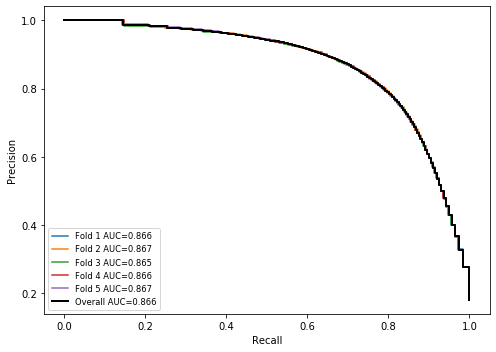

In [41]:
# Precision-Recall curve
fig, ax = plt.subplots(figsize=(7, 5))

y_binaries = []
y_probs = []

i = 0
for train_index, test_index in cv.split(X, y_binary):
    i += 1
    X_train, X_test = X.values.astype(float)[train_index], X.values.astype(float)[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probs[:,1])
    label = 'Fold %d AUC=%.3f' % (i, auc(recall, precision))
    ax.step(recall, precision, label=label)
    y_binaries.append(y_test)
    y_probs.append(probs[:,1])

y_binaries = np.concatenate(y_binaries)
y_probs = np.concatenate(y_probs)
precision, recall, _ = precision_recall_curve(y_binaries, y_probs)
label = 'Overall AUC=%.3f' % (auc(recall, precision))
ax.step(recall, precision, label=label, lw=2, color='black')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left', fontsize='small')

fig.tight_layout()
fig.savefig('result.png')